In [26]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy import ndimage
from scipy import linalg
from skimage.util.shape import view_as_windows
import random
import math
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import io
import radiomics
from enum import Enum
from radiomics.glcm import RadiomicsGLCM
import SimpleITK as sitk
import imageio
from itertools import product

In [27]:
# Read sample data.
img_s = sitk.ReadImage('../sample_data/ImageSlice.jpg')
mask_s = sitk.ReadImage('../sample_data/ImageMask.jpg')

In [28]:
# Turn image into a Numpy array.
img_array = sitk.GetArrayFromImage(img_s)
print(f'IMAGE:\nwidth={img_array.shape[0]} height={img_array.shape[1]}')

IMAGE:
width=440 height=596


In [29]:
class HaralickFeature(Enum):
    JointEntropy = ('JointEntropy', RadiomicsGLCM.getJointEntropyFeatureValue)
    JointEnergy = ('JointEnergy', RadiomicsGLCM.getJointEnergyFeatureValue)
    SumSquares = ('SumSquares', RadiomicsGLCM.getSumSquaresFeatureValue)
    Idm = ('Idm', RadiomicsGLCM.getIdmFeatureValue)
    Correlation = ('Correlation', RadiomicsGLCM.getCorrelationFeatureValue)
    Imc1 = ('Imc1', RadiomicsGLCM.getImc1FeatureValue)
    Imc2 = ('Imc2', RadiomicsGLCM.getImc2FeatureValue)
    SumAverage = ('SumAverage', RadiomicsGLCM.getSumAverageFeatureValue)
    ClusterTendency = ('ClusterTendency', RadiomicsGLCM.getClusterTendencyFeatureValue)
    SumEntropy = ('SumEntropy', RadiomicsGLCM.getSumEntropyFeatureValue)
    DifferenceAverage = ('DifferenceAverage', RadiomicsGLCM.getDifferenceAverageFeatureValue)
    DifferenceVariance = ('DifferenceVariance', RadiomicsGLCM.getDifferenceVarianceFeatureValue)
    DifferenceEntropy = ('DifferenceEntropy', RadiomicsGLCM.getDifferenceEntropyFeatureValue)

In [30]:
desired_haralick_feature = HaralickFeature.JointEntropy

In [31]:
# Create random window.
patch_window_size = random.randint(50, 150)
svd_window_size = random.randint(5, 20)
mask_center_x, mask_center_y = random.randint(patch_window_size, img_array.shape[1] - patch_window_size), random.randint(patch_window_size, img_array.shape[0] - patch_window_size)
print(f'WINDOW:\nCenter: x={mask_center_x} y={mask_center_y}; Size: width={patch_window_size} height={patch_window_size}')
mask_min_x = int(mask_center_x - patch_window_size/2)
mask_min_y = int(mask_center_y - patch_window_size/2)
mask_max_x = mask_min_x + patch_window_size
mask_max_y = mask_min_y + patch_window_size

WINDOW:
Center: x=175 y=132; Size: width=129 height=129


In [32]:
def show_colored_image(figure, axis, image_data, colormap=plt.cm.jet):
    image = axis.imshow(image_data, cmap=colormap)
    divider = make_axes_locatable(axis)
    colorbar_axis = divider.append_axes("right", size="5%", pad=0.05)
    figure.colorbar(image, cax=colorbar_axis)

def create_highlighted_rectangle(x, y, w, h):
    return Rectangle((x, y), w, h, linewidth=3, edgecolor='cyan', facecolor='none')

def highlight_rectangle_on_image(image_data, min_x, min_y, w, h, colormap=plt.cm.gray):
    figure, axes = plt.subplots(1,2, figsize=(15,15))

    # Highlight window within image.
    show_colored_image(figure, axes[0], image_data, colormap)
    axes[0].add_patch(create_highlighted_rectangle(min_x, min_y, w, h))

    # Crop window.
    cropped_array = image_data[min_y:min_y+h, min_x:min_x+w]
    axes[1].set_title(f'Cropped Region ({w}x{h})')
    show_colored_image(figure, axes[1], cropped_array, colormap)
    
    plt.show()
    
    return cropped_array

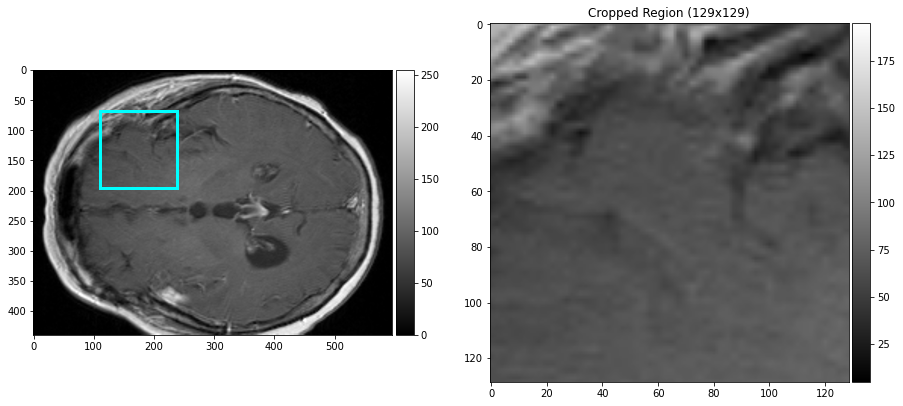

In [33]:
cropped_array = highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_size, patch_window_size)

In [34]:
cropped_padded_array = img_array[mask_min_x - int(svd_window_size / 2):mask_min_x + patch_window_size + int(svd_window_size / 2), mask_min_y - int(svd_window_size / 2):mask_min_y + patch_window_size + int(svd_window_size / 2)]

Text(0.5, 1.0, 'dy size=(129, 129)')

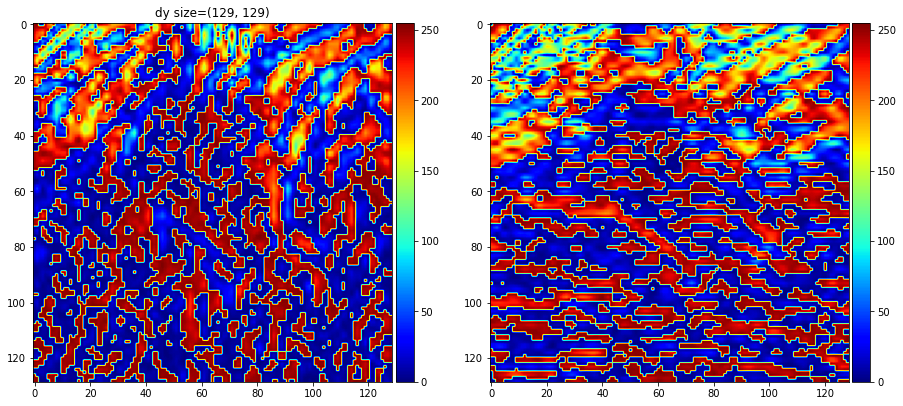

In [35]:
figure, axes = plt.subplots(1, 2, figsize=(15, 15))

# Define kernel for x differences.
kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

# Define kernel for y differences.
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Perform x convolution.
dx=ndimage.convolve(cropped_array[:, :, 0], kernel_x)

# Perform y convolution.
dy=ndimage.convolve(cropped_array[:, :, 0], kernel_y)

# Display dx & dy.
show_colored_image(figure, axes[0], dx)
axes[0].set_title(f'dx size={dx.shape}')
show_colored_image(figure, axes[1], dy)
axes[0].set_title(f'dy size={dy.shape}')

Creating windows:
Creating windows done.
Center x,y = 23, 78
dx Patch for SVD:


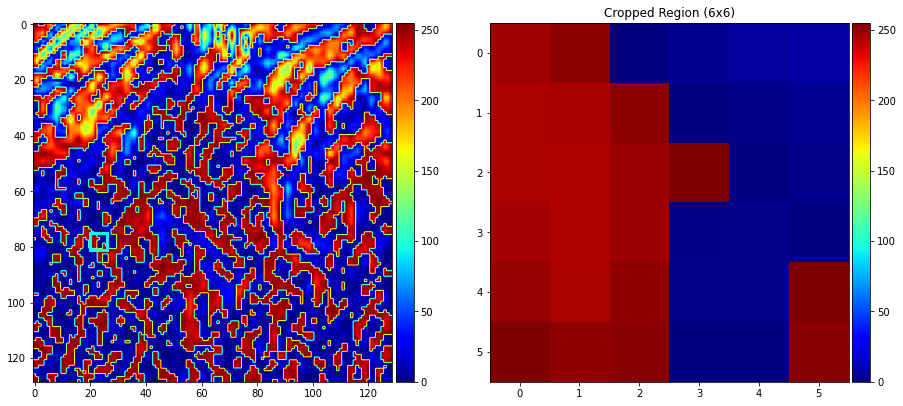

dy Patch for SVD:


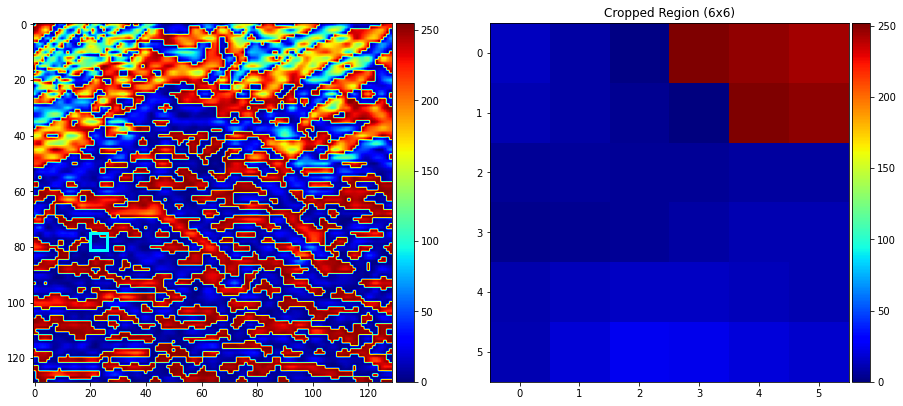

array([[ 14,   8,   1, 252, 248, 244],
       [ 11,   8,   4,   0, 252, 249],
       [  5,   6,   5,   5,   7,   7],
       [  3,   4,   5,   8,  11,  11],
       [ 10,  13,  15,  15,  13,  11],
       [ 11,  19,  25,  24,  20,  17]], dtype=uint8)

In [36]:
# Create windows.
print('Creating windows:')
dx_windows = view_as_windows(dx, (svd_window_size, svd_window_size))
dy_windows = view_as_windows(dy, (svd_window_size, svd_window_size))
print('Creating windows done.')

# Extract a random patch
svd_center_x = random.randint(int(svd_window_size/2),dx_windows.shape[1]-int(svd_window_size/2))
svd_center_y = random.randint(int(svd_window_size/2),dx_windows.shape[1]-int(svd_window_size/2))

print(f'Center x,y = {svd_center_x}, {svd_center_y}')

# Get window at x,y.
dx_patch = dx_windows[svd_center_y, svd_center_x]
dy_patch = dy_windows[svd_center_y, svd_center_x]

# Display windows.
svd_min_x = svd_center_x - int(svd_window_size/2)
svd_min_y = svd_center_y - int(svd_window_size/2)
print('dx Patch for SVD:')
highlight_rectangle_on_image(dx, svd_min_x, svd_min_y, svd_window_size, svd_window_size, plt.cm.jet)
print('dy Patch for SVD:')
highlight_rectangle_on_image(dy, svd_min_x, svd_min_y, svd_window_size, svd_window_size, plt.cm.jet)

In [37]:
def svd_dominant_angle(x, y, dx_windows, dy_windows, window_size):
    dx_patch = dx_windows[y, x]
    dy_patch = dy_windows[y, x]
    window_area = window_size * window_size
    flattened_gradients = np.zeros((window_area, 2))
    #print(f'Flattened gradients shape = {flattened_gradients.shape}')
    flattened_gradients[:,0] = np.reshape(dx_patch, ((window_area)))
    flattened_gradients[:,1] = np.reshape(dy_patch, ((window_area)))
    #print('Calculating svd...', flush=True)
    U, S, V = linalg.svd(flattened_gradients)
    #print('Calculating svd done.', flush=True)
    #print(f'V (from SVD) = \n{V}')
    dominant_angle = math.atan2(V[0, 0], V[0, 1])
    #print(f'Dominant angle = atan2({V[0, 0]}/{V[0, 1]})={dominant_angle}')
    return dominant_angle

Calculating svd:
Calculating svd done.


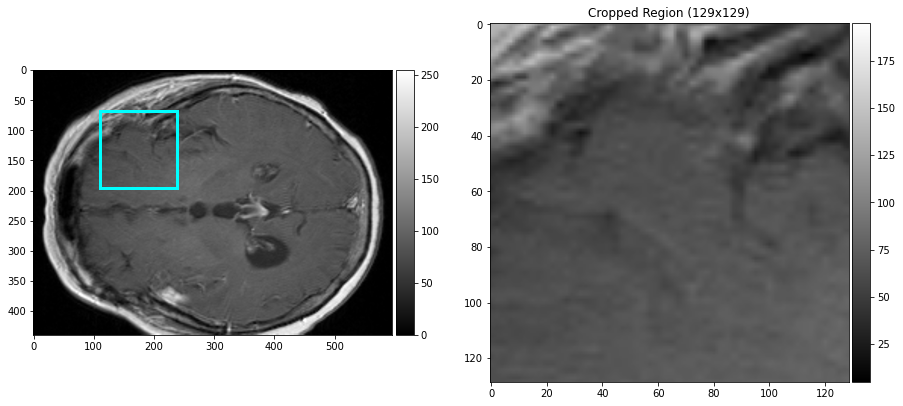

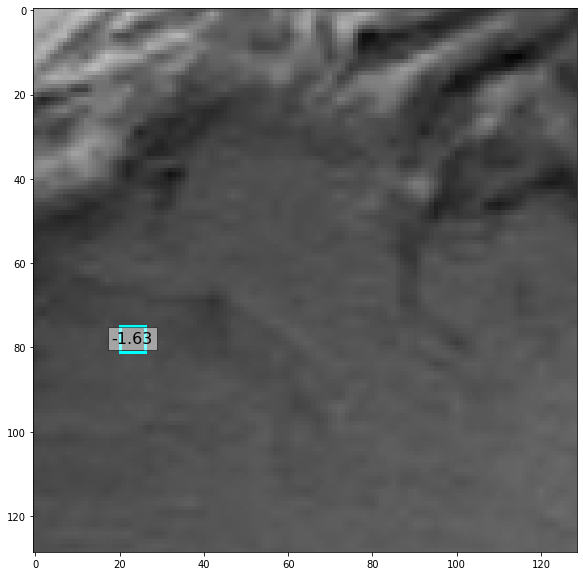

In [38]:
print('Calculating svd:')
dominant_angle = svd_dominant_angle(svd_center_x, svd_center_y, dx_windows, dy_windows, svd_window_size)
print('Calculating svd done.')

# Show highlighted region.
highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_size, patch_window_size)

# Overlay dominant angle on top of window.
figure, axis = plt.subplots(1, 1, figsize=(10, 10))
image_patch_array = img_array[mask_min_y:mask_max_y, mask_min_x:mask_max_x]
axis.imshow(image_patch_array, cmap=plt.cm.gray)
axis.add_patch(create_highlighted_rectangle(svd_min_x, svd_min_y, svd_window_size, svd_window_size))
axis.text(svd_min_x + svd_window_size / 2, svd_min_y + svd_window_size / 2, round(dominant_angle, 2), fontsize=16, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [39]:
def arrow_for_window(window_array, center_x, center_y, window_size, dominant_angle):
    arrow_dx = math.cos(dominant_angle) * window_size / 1.1
    arrow_dy = math.sin(dominant_angle) * window_size / 1.1 * -1
    arrow_x = center_x
    arrow_y = center_y
#     print(f'x={arrow_x} y={arrow_y} dx={arrow_dx} dy={arrow_dy}')
    return mpatches.Arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, width=window_size / 2, color='orange')

In [40]:
def show_arrow_on_window(window_array, center_x, center_y, window_size, dominant_angle):
    fig, ax = plt.subplots(1)
    ax.imshow(window_array, cmap=plt.cm.gray)
    ax.add_patch(arrow_for_window(window_array, center_x, center_y, window_size, dominant_angle))
    plt.show()

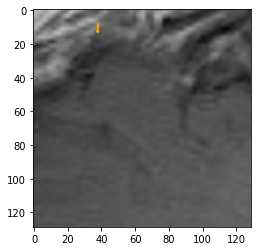

In [41]:
show_arrow_on_window(cropped_array, haralick_center_x, haralick_center_y, svd_window_size, dominant_angle)

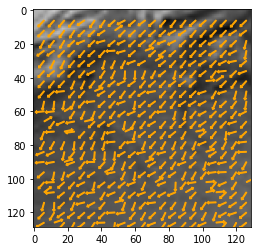

In [42]:
fig, ax = plt.subplots(1)
ax.imshow(cropped_array, cmap=plt.cm.gray)
half_window = int(svd_window_size / 2)
for x in range(0, dx_windows.shape[0] - half_window, svd_window_size):
    for y in range(0, dy_windows.shape[1] - half_window, svd_window_size):
        dominant_angle = svd_dominant_angle(x + half_window, y + half_window, dx_windows, dy_windows, svd_window_size)
        ax.add_patch(arrow_for_window(cropped_array, x + svd_window_size, y + svd_window_size, svd_window_size, dominant_angle))
plt.show()

In [46]:
# loop through all regions and calculate dominant angles
print('Calculating dominant angles:')
dominant_angles_array = np.zeros_like(cropped_array, np.single)
print(f'dx shape = {dx.shape}')
print(f'dominant angles shape = {dominant_angles_array.shape}')
print(f'svd window size = {svd_window_size}')
center_x_range = range(int(svd_window_size/2), dx.shape[1]-2-int(svd_window_size/2))
center_y_range = range(int(svd_window_size/2), dx.shape[0]-2-int(svd_window_size/2))
for current_svd_center_x in center_x_range:
    for current_svd_center_y in center_y_range:
        current_dominant_angle = svd_dominant_angle(
            current_svd_center_x, current_svd_center_y,
            dx_windows, dy_windows, svd_window_size)
        dominant_angles_array[current_svd_center_y, current_svd_center_x] = current_dominant_angle
        if (random.randint(0,500)==0):
            print(f'x={current_svd_center_x}, y={current_svd_center_y}')
            print(f'angle={current_dominant_angle}')
print('Done calculating dominant angles.')

Calculating dominant angles:
dx shape = (129, 129)
dominant angles shape = (129, 129, 3)
svd window size = 6
x=13, y=86
angle=-2.8059942917242946
x=15, y=64
angle=-2.710717458011751
x=20, y=107
angle=-2.1998630027681534
x=25, y=74
angle=-2.5607000668148854
x=32, y=47
angle=-2.840914007875656
x=32, y=86
angle=-3.1215672405260113
x=33, y=37
angle=0.5278407306294156
x=36, y=20
angle=-2.329310558355764
x=52, y=99
angle=-2.3484194747824416
x=57, y=63
angle=-2.0653941963100544
x=58, y=43
angle=-2.413089884226213
x=69, y=49
angle=-2.75639883640772
x=91, y=24
angle=-2.4123687660332913
x=94, y=89
angle=-2.949053911832509
x=101, y=109
angle=-3.0498792264320995
x=106, y=41
angle=-2.430397444202804
x=106, y=121
angle=-2.939858807815512
x=112, y=100
angle=-2.9838523374409607
x=113, y=117
angle=-2.337906364505997
x=115, y=122
angle=-1.8696363064489168
x=116, y=74
angle=-2.13729488961488
x=116, y=94
angle=-1.9829009583616692
x=120, y=27
angle=0.4116160854647756
Done calculating dominant angles.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-2.2345827 -2.2345827 -2.2345827]
  [-2.2785792 -2.2785792 -2.2785792]
  [-2.2871318 -2.2871318 -2.2871318]
  [-2.3163917 -2.3163917 -2.3163917]
  [-2.2874749 -2.2874749 -2.2874749]
  [-2.3775053 -2.3775053 -2.3775053]]

 [[-2.1960034 -2.1960034 -2.1960034]
  [-2.2265754 -2.2265754 -2.2265754]
  [-2.2523937 -2.2523937 -2.2523937]
  [-2.2984445 -2.2984445 -2.2984445]
  [-2.283622  -2.283622  -2.283622 ]
  [-2.395991  -2.395991  -2.395991 ]]

 [[-2.1955552 -2.1955552 -2.1955552]
  [-2.2268088 -2.2268088 -2.2268088]
  [-2.2499564 -2.2499564 -2.2499564]
  [-2.330205  -2.330205  -2.330205 ]
  [-2.3262753 -2.3262753 -2.3262753]
  [-2.3991735 -2.3991735 -2.3991735]]

 [[-2.1087    -2.1087    -2.1087   ]
  [-2.1765127 -2.1765127 -2.1765127]
  [-2.2200725 -2.2200725 -2.2200725]
  [-2.3316333 -2.3316333 -2.3316333]
  [-2.3500328 -2.3500328 -2.3500328]
  [-2.4458544 -2.4458544 -2.4458544]]

 [[-2.0613644 -2.0613644 -2.0613644]
  [-2.1510327 -2.1510327 -2.1510327]
  [-2.223682  -2.223682  -2.22

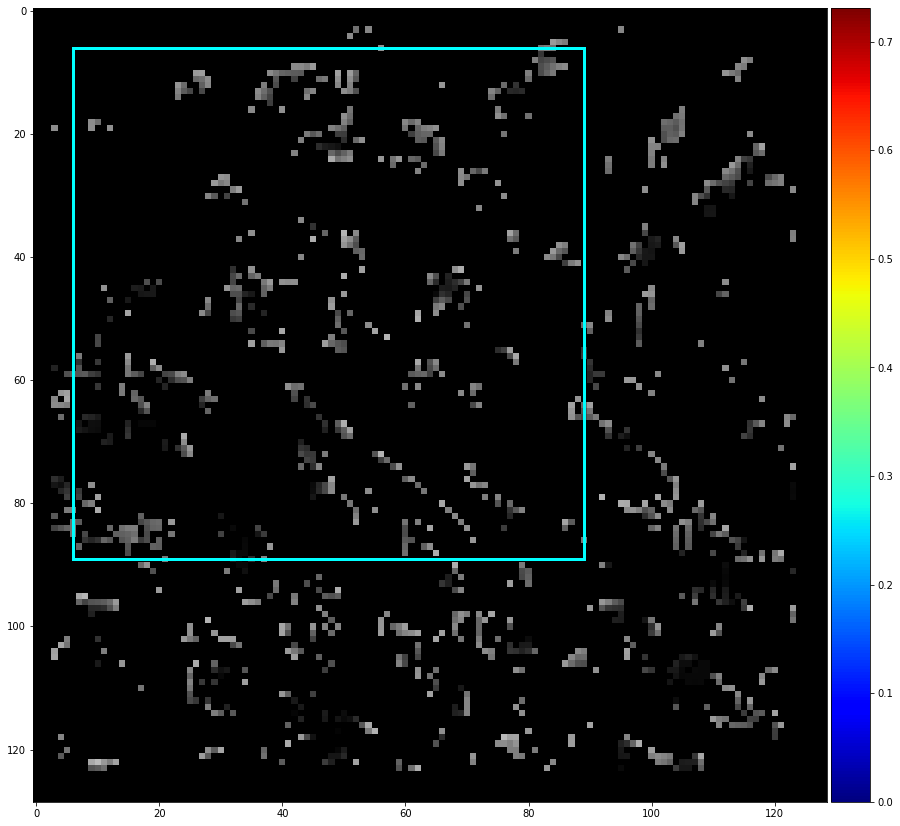

In [51]:
figure, axis = plt.subplots(1, 1, figsize=(15,15))
show_colored_image(figure, axis, dominant_angles_array, plt.cm.jet)
axis.add_patch(create_highlighted_rectangle(svd_window_size, svd_window_size, w, h))
print(dominant_angles_array[svd_window_size:svd_window_size*2,svd_window_size:svd_window_size*2])

In [20]:
haralick_image = np.zeros(cropped_array.shape, dtype=np.uint8)

In [21]:
def get_haralick(sitk_image, img_array, x, y, window_size, haralick_feature):
    haralick_mask = np.full(img_array.shape, 0)
    haralick_mask[x:x + window_size, y:y + window_size] = [1, 1, 1]
    sitk_mask = sitk.GetImageFromArray(haralick_mask)
    haralick = RadiomicsGLCM(sitk_image, sitk_mask)
    haralick.enableFeatureByName(haralick_feature.value[0])
    haralick.execute()
    return haralick_feature.value[1](haralick)[0]

In [22]:
sitk_cropped_image = sitk.GetImageFromArray(cropped_array)
cropped_image_mask_array = np.full(img_array.shape, 0)
h, w, a = cropped_array.shape
for pos in product(range(h), range(w)):
   result = get_haralick(sitk_cropped_image, cropped_array, pos[0], pos[1], haralick_window_size, desired_haralick_feature)
   haralick_image[pos[0], pos[1]] = [int(result * 255), int(result * 255), int(result * 255)]

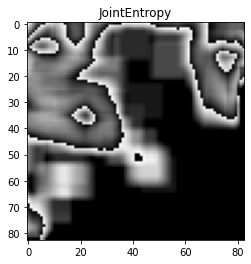

In [23]:
plt.title(desired_haralick_feature.value[0])
plt.imshow(haralick_image, cmap=plt.cm.jet)